# Benchmark

In [161]:
import os
from sys import argv
rootdir = argv[1]

#############################
#      FOR NOTEBOOK USE     #
#     SET DIRECTORY HERE    #
#                           #
rootdir = "test_dir_5"
#                           #
#############################

print("Using root directory: {}".format(rootdir))

# Get the subdirs with the different tests
subdirs = sorted([ name for name in os.listdir('{}'.format(rootdir)) if os.path.isdir(os.path.join('{}'.format(rootdir), name)) ])
print("Available subdirs: {}".format(subdirs))

Using root directory: test_dir_5
Available subdirs: ['infiniband_RC_20181016_01-16-06', 'infiniband_UC_20181016_01-17-36', 'infiniband_UD_20181016_01-19-06']


In [177]:
import json
from sys import exit

#try:
with open("{}/settings.json".format(rootdir)) as json_file:
    settings = json.load(json_file)
#except:
#    print("Please define a correct JSON file!")
#    exit()

print("Succesfully loaded JSON file")

Succesfully loaded JSON file


## Load all files
A group that will be one line in the summarizing graph is a *node-type* + *mode* combination. This group contains the variable *rate*. See the following three groups as example:

* InfiniBand (RC): 1KHz, 10KHz, 50KHz, 100KHz
* InfiniBand (UD): 1KHz, 10KHz, 50KHz, 100KHz
* MQTT (UDP): 1KHz, 10KHz, 50KHz

## Save characteristics of tests
All important settings are contained in the name of the file. We will save them in a separate array. The structure of the name is as follows:

```bash
root_dir/benchmarks_${DATE}/${ID}_${MODE}-${VALUES IN SMP}-${RATE}-${SENT SMPS}
```

Thus, we will structure it in the settings_array as follows:

* `settings_array[*][0] = ID`
* `settings_array[*][1] = MODE`
* `settings_array[*][2] = VALUES IN SAMPLE`
* `settings_array[*][3] = RATE`
* `settings_array[*][4] = TOTAL NUMBER OF SAMPLES`

In [163]:
import numpy as np
import os
import re

# First, source log

# Initialize arrays
input_dataset = []
output_dataset = []
settings_array = []


for i, subdir in enumerate(subdirs):
    input_dataset.append([])
    output_dataset.append([])

    # Acquire node type from the directory
    matchObj = re.match(r'(\w*)_2\w*', subdir, re.M|re.I)
    
    # Fill value to array
    if matchObj:
        node_type = matchObj[1]

    # Acquire all tests in that subdirectory
    for walk_subdir, dirs, files in sorted(os.walk("{}/{}".format(rootdir, subdir))):
        input_dataset.append([])
        output_dataset.append([])
        settings_array.append([])
        
        for file in sorted(files):
            ############################
            ###### SAVE SETTINGS #######
            ############################
            temp_settings = []
            temp_settings.append(node_type)
        
            # Match settings, as described above
            matchObj = re.match(r'.*?(\d*)_(\w*)-(\d*)-(\d*)-(\d*)_output.csv', file, re.M|re.I)

            # Fill values to array
            if matchObj:
                for j in range(0,5):
                    temp_settings.append(matchObj.group(j + 1))
    
                # Append array to big array
                settings_array[i].append(temp_settings)
            
            ############################
            ######### LOAD DATA ########
            ############################
      
            # Regex to match input files
            if re.match(r'.*?_input.csv', file, re.M|re.I):
                #input_paths.append(os.path.join(subdir, file))
                    
                # Load file 
                input_dataset[i].append(np.genfromtxt("{}/{}/{}".format(rootdir, subdir, file), delimiter=','))
                
                print("Loaded input dataset from: {}".format(file))

            # Regex to match output files files
            elif re.match(r'.*?_output.csv', file, re.M|re.I):
                #output_paths.append(os.path.join(subdir, file))
                
                output_dataset[i].append(np.genfromtxt("{}/{}/{}".format(rootdir, subdir, file), delimiter=','))
                
                print("Loaded output dataset from: {}".format(file))

    print("Settings for this subdirectory: ")
    print(settings_array[i])
    print("\n")

    # Small sanity check, are arrays of the same size?
    if len(input_dataset[i]) != len(output_dataset[i]):
        print("Error: There should be as many input files as there are output files!")
        exit();

Loaded input dataset from: 0_RC-10-100-500_input.csv
Loaded output dataset from: 0_RC-10-100-500_output.csv
Loaded input dataset from: 1_RC-10-1000-5000_input.csv
Loaded output dataset from: 1_RC-10-1000-5000_output.csv
Loaded input dataset from: 2_RC-10-10000-50000_input.csv
Loaded output dataset from: 2_RC-10-10000-50000_output.csv
Loaded input dataset from: 3_RC-10-25000-125000_input.csv
Loaded output dataset from: 3_RC-10-25000-125000_output.csv
Loaded input dataset from: 4_RC-10-50000-250000_input.csv
Loaded output dataset from: 4_RC-10-50000-250000_output.csv
Loaded input dataset from: 5_RC-10-100000-500000_input.csv
Loaded output dataset from: 5_RC-10-100000-500000_output.csv
Settings for this subdirectory: 
[['infiniband_RC', '0', 'RC', '10', '100', '500'], ['infiniband_RC', '1', 'RC', '10', '1000', '5000'], ['infiniband_RC', '2', 'RC', '10', '10000', '50000'], ['infiniband_RC', '3', 'RC', '10', '25000', '125000'], ['infiniband_RC', '4', 'RC', '10', '50000', '250000'], ['infini

## Get missed steps from source node
...

In [164]:
# Number of missing samples at receive side
missed_send_arr = []
# Percentage of missed samples
perc_miss_send_arr = []

# Generate real total and number of missing samples.
# Print percentage of missed samples
for i, subdir in enumerate(subdirs):
    missed_send_arr.append([])
    perc_miss_send_arr.append([])
    
    for (j, csv_vec) in enumerate(input_dataset[i]):
        # Get number of missing samples
        missed_send_arr[i].append(int(settings_array[i][j][5]) - len(csv_vec))

        # Take percentage
        perc_miss_send_arr[i].append(round(missed_send_arr[i][j] / int(settings_array[i][j][5]) * 100, 2))
        
        print("Test {} ({}) is missing {} ({}%) of {} in in-file."
              .format(settings_array[i][j][0], settings_array[i][j][2], missed_send_arr[i][j], 
                      perc_miss_send_arr[i][j], settings_array[i][j][5]))

Test infiniband_RC (RC) is missing 0 (0.0%) of 500 in in-file.
Test infiniband_RC (RC) is missing 10 (0.2%) of 5000 in in-file.
Test infiniband_RC (RC) is missing 137 (0.27%) of 50000 in in-file.
Test infiniband_RC (RC) is missing 362 (0.29%) of 125000 in in-file.
Test infiniband_RC (RC) is missing 672 (0.27%) of 250000 in in-file.
Test infiniband_RC (RC) is missing 2768 (0.55%) of 500000 in in-file.
Test infiniband_UC (UC) is missing 668 (0.27%) of 250000 in in-file.
Test infiniband_UC (UC) is missing 2563 (0.51%) of 500000 in in-file.
Test infiniband_UC (UC) is missing 0 (0.0%) of 500 in in-file.
Test infiniband_UC (UC) is missing 10 (0.2%) of 5000 in in-file.
Test infiniband_UC (UC) is missing 138 (0.28%) of 50000 in in-file.
Test infiniband_UC (UC) is missing 338 (0.27%) of 125000 in in-file.
Test infiniband_UD (UD) is missing 0 (0.0%) of 500 in in-file.
Test infiniband_UD (UD) is missing 11 (0.22%) of 5000 in in-file.
Test infiniband_UD (UD) is missing 142 (0.28%) of 50000 in in-f

## Get missed steps from destination node
...

In [171]:
# Number of missing samples at receive side
missed_recv_arr = []
# Percentage of missed samples
perc_miss_recv_arr = []

# Generate real total and number of missing samples.
# Print percentage of missed samples
for i, subdir in enumerate(subdirs):
    missed_recv_arr.append([])
    perc_miss_recv_arr.append([])

    for (j, csv_vec) in enumerate(output_dataset[i]):

        # Get number of missing samples
        missed_recv_arr[i].append(int(settings_array[i][j][5]) - len(csv_vec))

        # Take percentage
        perc_miss_recv_arr[i].append(round(missed_recv_arr[i][j] / int(settings_array[i][j][5]) * 100, 2))

        print("Test {} ({}) is missing {} ({}%) of {} in out-file."
              .format(settings_array[i][j][0], settings_array[i][j][2], missed_recv_arr[i][j], 
                      perc_miss_recv_arr[i][j], settings_array[i][j][5]))

Test infiniband_RC (RC) is missing 1 (0.2%) of 500 in out-file.
Test infiniband_RC (RC) is missing 15 (0.3%) of 5000 in out-file.
Test infiniband_RC (RC) is missing 171 (0.34%) of 50000 in out-file.
Test infiniband_RC (RC) is missing 444 (0.36%) of 125000 in out-file.
Test infiniband_RC (RC) is missing 858 (0.34%) of 250000 in out-file.
Test infiniband_RC (RC) is missing 3056 (0.61%) of 500000 in out-file.
Test infiniband_UC (UC) is missing 838 (0.34%) of 250000 in out-file.
Test infiniband_UC (UC) is missing 2849 (0.57%) of 500000 in out-file.
Test infiniband_UC (UC) is missing 1 (0.2%) of 500 in out-file.
Test infiniband_UC (UC) is missing 16 (0.32%) of 5000 in out-file.
Test infiniband_UC (UC) is missing 174 (0.35%) of 50000 in out-file.
Test infiniband_UC (UC) is missing 424 (0.34%) of 125000 in out-file.
Test infiniband_UD (UD) is missing 1 (0.2%) of 500 in out-file.
Test infiniband_UD (UD) is missing 15 (0.3%) of 5000 in out-file.
Test infiniband_UD (UD) is missing 171 (0.34%) of

## Check first and second sample from receive & destination node
...

In [172]:
# Check first and second sample

first_second_smp_input = []
first_second_smp_output = []

for i, subdir in enumerate(subdirs):
    first_second_smp_input.append([])
    first_second_smp_output.append([])
    
    for (j, csv_vec) in enumerate(input_dataset[i]):
        first_second_smp_input[i].append([csv_vec[0][3], csv_vec[1][3]])
        print("First and second sample of test {} ({}): {} and {}, respectively".format(settings_array[i][j][0],
                                                                                   settings_array[i][j][2],
                                                                                   int(first_second_smp_input[i][j][0]),
                                                                                   int(first_second_smp_input[i][j][1])))

    for (j, csv_vec) in enumerate(output_dataset[i]):
        first_second_smp_output[i].append([csv_vec[0][3], csv_vec[1][3]])
        print("First and second sample of test {} ({}): {} and {}, respectively".format(settings_array[i][j][0],
                                                                                   settings_array[i][j][2],
                                                                                   int(first_second_smp_output[i][j][0]),
                                                                                   int(first_second_smp_output[i][j][1])))
        
    print("")
    

First and second sample of test infiniband_RC (RC): 0 and 1, respectively
First and second sample of test infiniband_RC (RC): 0 and 1, respectively
First and second sample of test infiniband_RC (RC): 0 and 1, respectively
First and second sample of test infiniband_RC (RC): 0 and 1, respectively
First and second sample of test infiniband_RC (RC): 0 and 1, respectively
First and second sample of test infiniband_RC (RC): 0 and 1, respectively
First and second sample of test infiniband_RC (RC): 1 and 2, respectively
First and second sample of test infiniband_RC (RC): 5 and 6, respectively
First and second sample of test infiniband_RC (RC): 34 and 35, respectively
First and second sample of test infiniband_RC (RC): 82 and 83, respectively
First and second sample of test infiniband_RC (RC): 186 and 187, respectively
First and second sample of test infiniband_RC (RC): 288 and 289, respectively

First and second sample of test infiniband_UC (UC): 0 and 1, respectively
First and second sample o

## Compare input and output data sets
...

In [173]:
missing_seq = []

never_trans_total_arr = []
never_trans_after_arr = []

perc_never_trans_total_arr = []
perc_never_trans_after_arr = []

# Loop through input_array, since this is always bigger or equal to output array
for i, subdir in enumerate(subdirs):
    never_trans_total_arr.append([])
    never_trans_after_arr.append([])
    
    perc_never_trans_total_arr.append([])
    perc_never_trans_after_arr.append([])
    
    missing_seq.append([])
    
    for (j, csv_vec) in enumerate(input_dataset[i]):    
        l = 0
        missing_seq[i].append([])
        for (k, line) in enumerate(csv_vec):      
            try:
                if line[3] != output_dataset[i][j][l][3]:
                    missing_seq[i][j].append(line[3])
                else:
                    l += 1

            except IndexError:
                pass

        never_trans_total_arr[i].append(len(missing_seq[i][j]))

        never_trans_after_arr[i].append(np.sum(missing_seq[i][j] > first_second_smp_output[i][j][0]))

        # Take percentage
        perc_never_trans_total_arr[i].append(round(never_trans_total_arr[i][j] / int(settings_array[i][j][4]) * 100, 2))
        perc_never_trans_after_arr[i].append(round(never_trans_after_arr[i][j] / int(settings_array[i][j][4]) * 100, 2))

        print("Test {} ({}): {} ({}%) samples were never transferred ".format(settings_array[i][j][0],
                                                                              settings_array[i][j][2],
                                                                              never_trans_total_arr[i][j],
                                                                              perc_never_trans_total_arr[i][j]))
        print("{} ({}%) of these after the first sample occured in out-file.".format(never_trans_after_arr[i][j],
                                                                                     perc_never_trans_after_arr[i][j]))

        print("")

Test infiniband_RC (RC): 1 (1.0%) samples were never transferred 
0 (0.0%) of these after the first sample occured in out-file.

Test infiniband_RC (RC): 5 (0.5%) samples were never transferred 
0 (0.0%) of these after the first sample occured in out-file.

Test infiniband_RC (RC): 34 (0.34%) samples were never transferred 
0 (0.0%) of these after the first sample occured in out-file.

Test infiniband_RC (RC): 82 (0.33%) samples were never transferred 
0 (0.0%) of these after the first sample occured in out-file.

Test infiniband_RC (RC): 186 (0.37%) samples were never transferred 
0 (0.0%) of these after the first sample occured in out-file.

Test infiniband_RC (RC): 288 (0.29%) samples were never transferred 
0 (0.0%) of these after the first sample occured in out-file.

Test infiniband_UC (UC): 170 (0.34%) samples were never transferred 
0 (0.0%) of these after the first sample occured in out-file.

Test infiniband_UC (UC): 286 (0.29%) samples were never transferred 
0 (0.0%) of the

## Calculate medians

In [174]:
medians = []
upper_limit = []
lower_limit = []

for i, subdir in enumerate(subdirs):
    medians.append([])
    upper_limit.append([])
    lower_limit.append([])
    
    for (j, csv_vec) in enumerate(output_dataset[i]):  
        medians[i].append(np.median(csv_vec.transpose()[2]) * 1e6)
        
         # np.sort(recv[i][j] - enq_send[i][j])[int(np.size(recv[i][j]]) / 2)] would be the approximately the median
        # Calculate upper 10% and lower 10%
        upper_limit[i].append(abs(medians[i][j] - 1e6 * np.sort(csv_vec.transpose()[2])[int(9 * np.size(csv_vec.transpose()[2]) / 10)]))
        lower_limit[i].append(abs(medians[i][j] - 1e6 * np.sort(csv_vec.transpose()[2])[int(1 * np.size(csv_vec.transpose()[2]) / 10)]))

## Plot data
...

In [175]:
# Define Fancy Box function we use
def plot_fancy_box(bottom, height):
    top = bottom + height
    
    p = FancyBboxPatch((left, bottom),
                       width,
                       height,
                       boxstyle="round, pad=0.005",
                       
                       ec="#dbdbdb", 
                       fc="white", 
                       alpha=0.85,
                       transform=ax.transAxes
                      )
    
    ax.add_patch(p)
    
    
# Define "find nearest" function
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx], idx

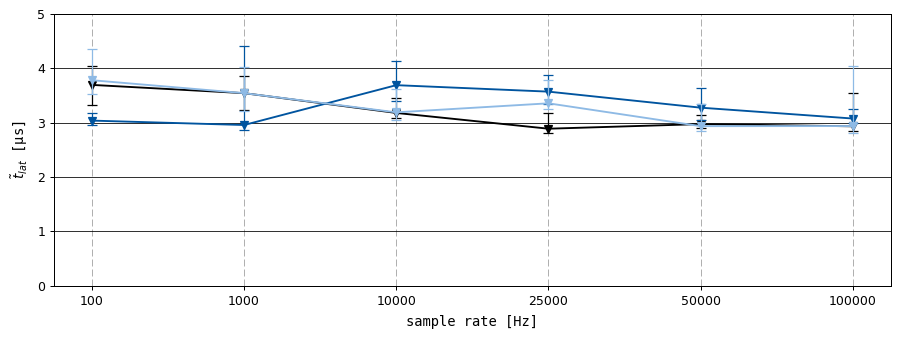

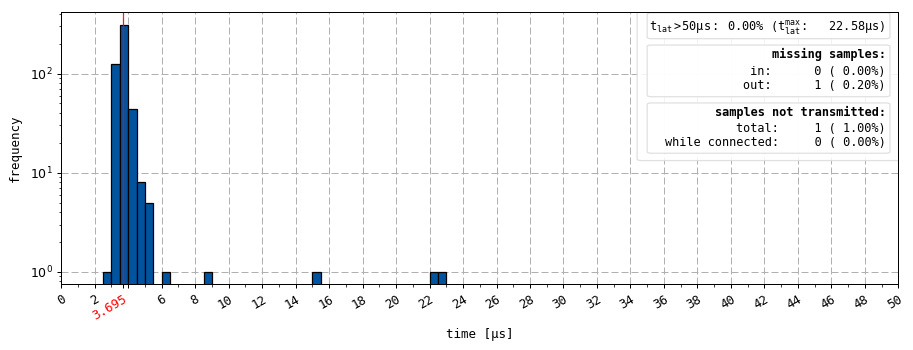

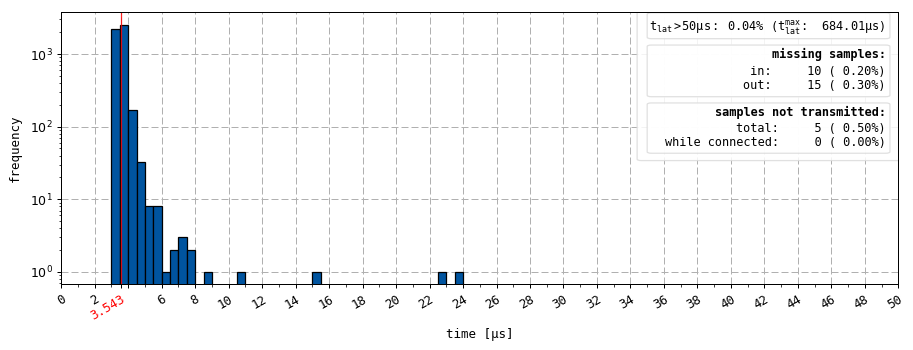

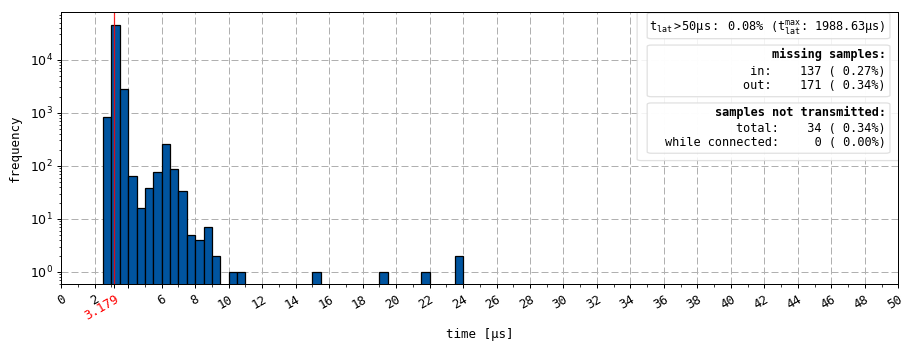

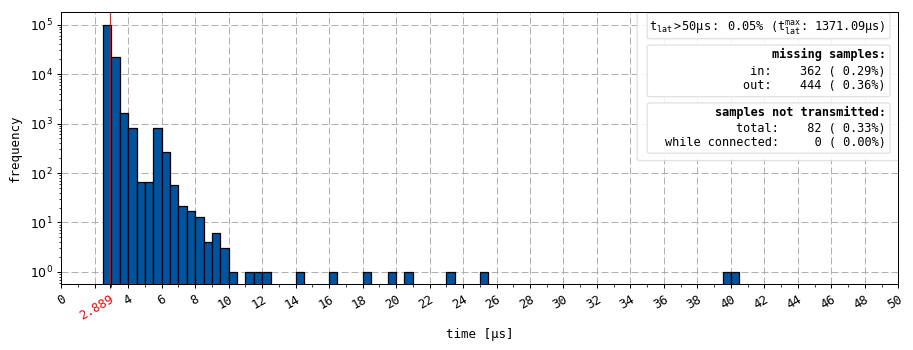

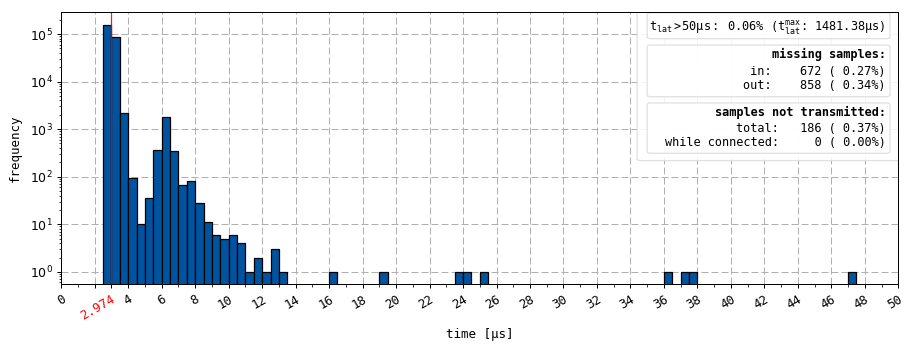

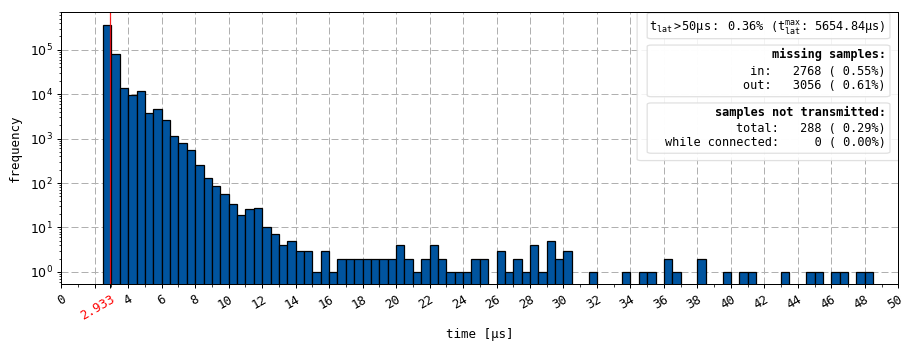

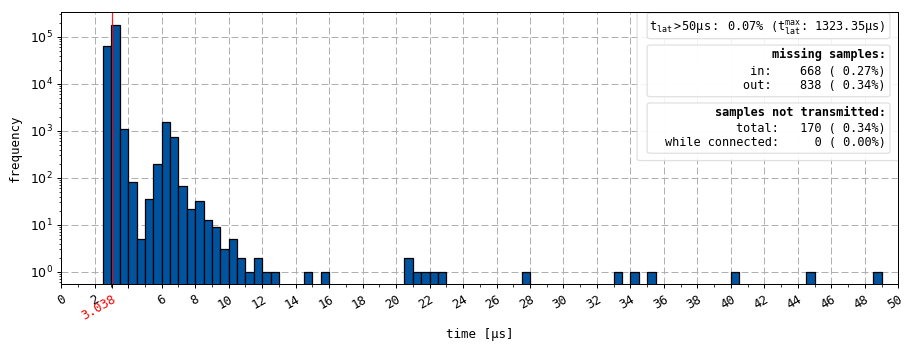

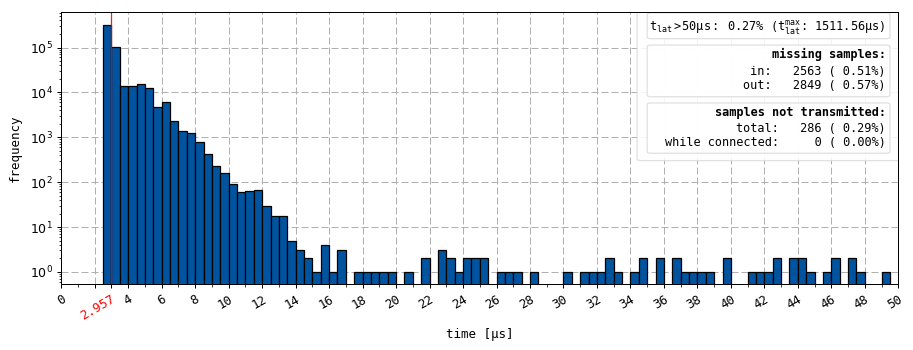

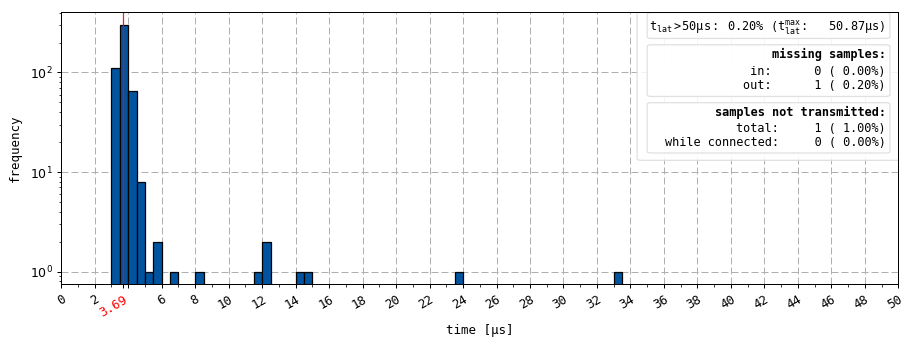

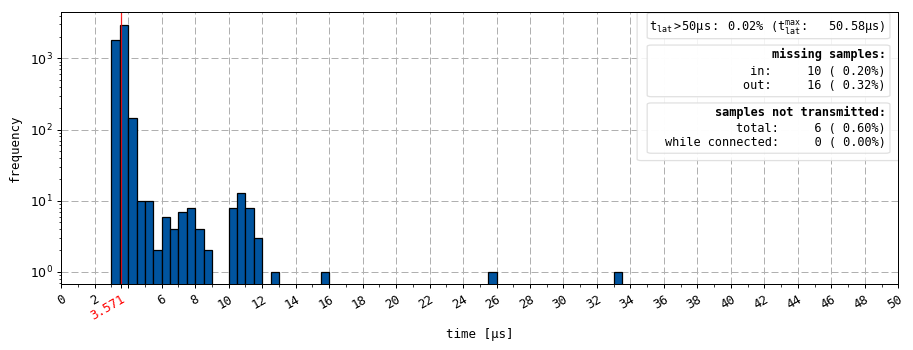

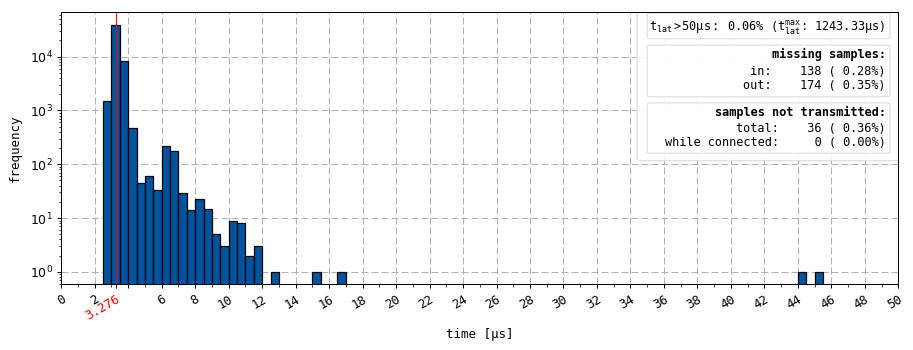

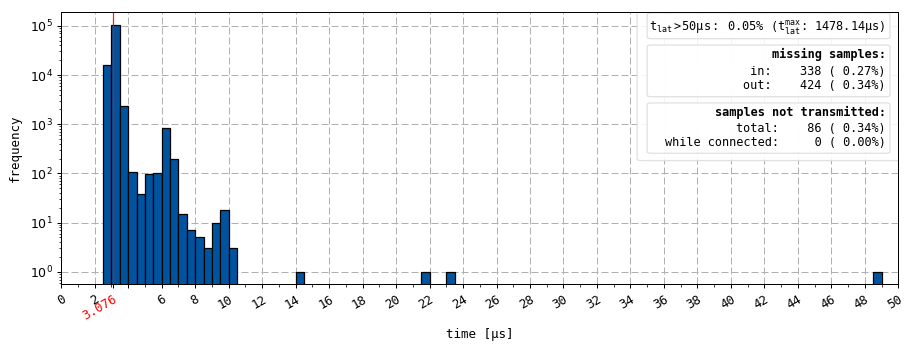

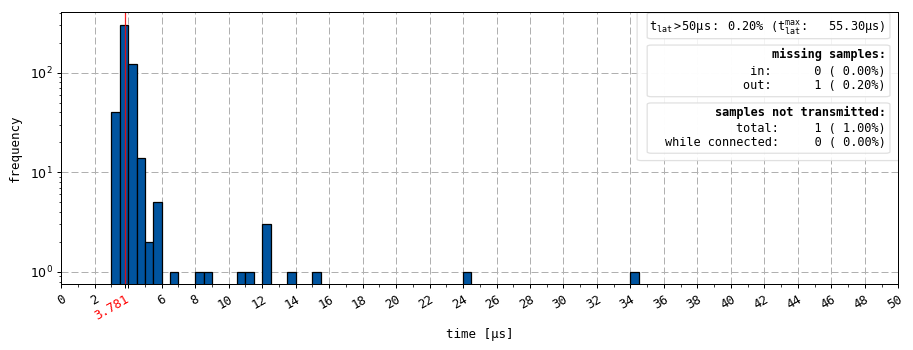

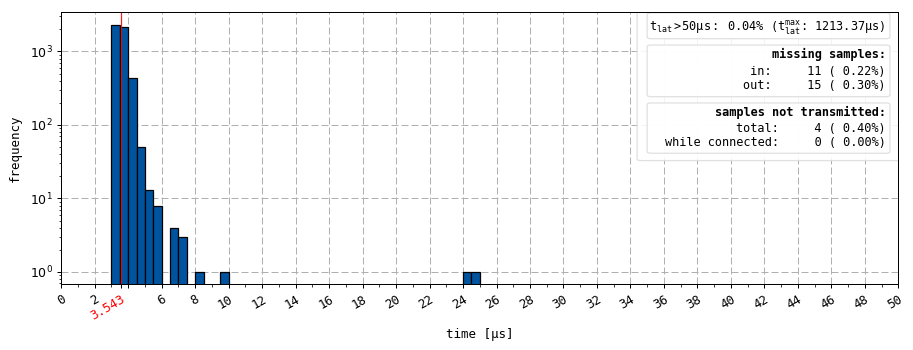

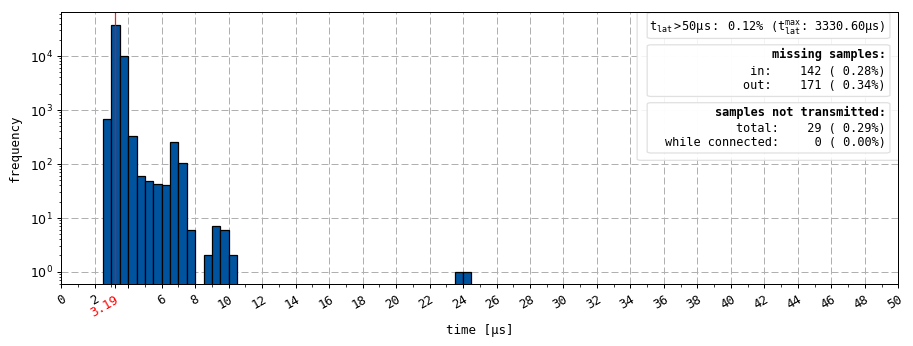

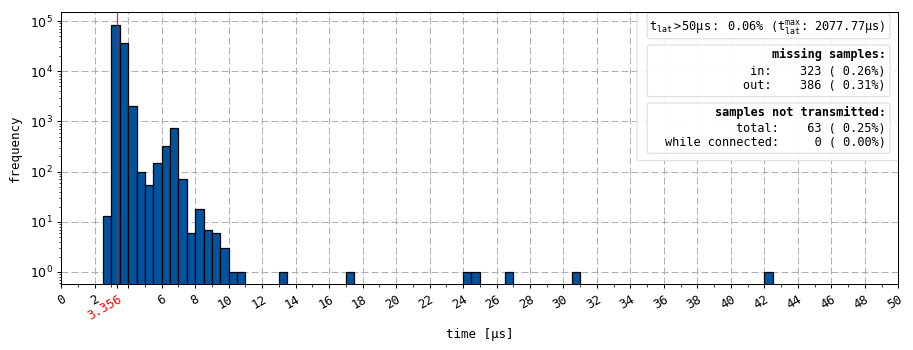

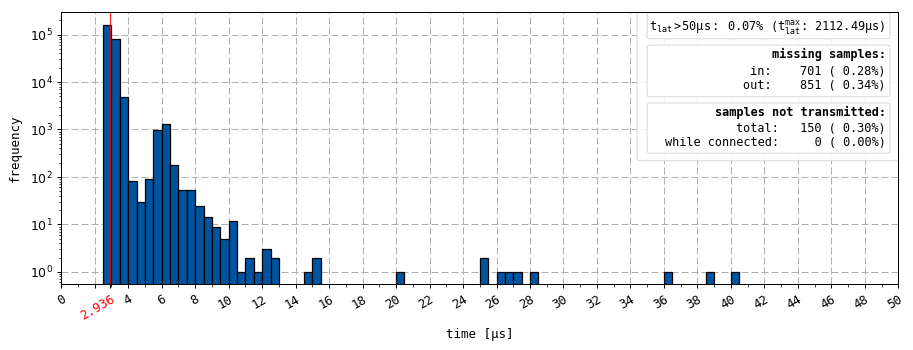

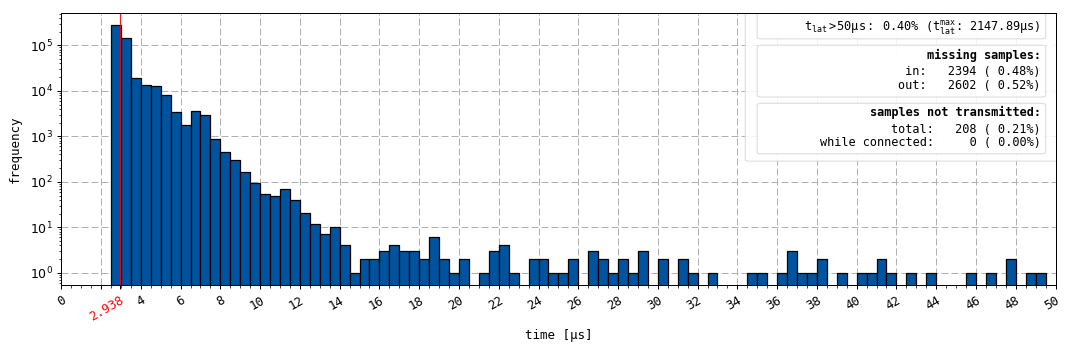

In [178]:
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
from matplotlib.patches import FancyBboxPatch
import os

# Start creating plots
# Create figure for median plot
fig_median = plt.figure(num=None, figsize=(12, 4), dpi=90, facecolor='w', edgecolor='k')

# Add plot and set title
ax_median = fig_median.add_subplot(111)

y_data = np.array([])

for i, subdir in enumerate(subdirs):
    
    x_data = np.array([])
    for k in range(0, len(medians[i])):
        x_data = np.append(x_data, k)

    ax_median.errorbar(x_data, medians[i], yerr=[lower_limit[i], upper_limit[i]],
                       capsize = 3.7, elinewidth = 1, markeredgewidth = 1, 
                       marker='v', zorder = 2 + i, color=settings['median_plot']['colors'][i])
        

    for (j, csv_vec) in enumerate(output_dataset[i]):

        # Create figure
        fig = plt.figure(num=None, figsize=(12, 4), dpi=90, facecolor='w', edgecolor='k')

        # Add plot and set title
        ax = fig.add_subplot(111)

        # Set grid
        ax.set_axisbelow(True)
        ax.grid(True, linestyle='--')

        x_limit = 0.00005
        bins = np.arange(0, 50, 50 / 100)

        # Data in plot
        # http://www.color-hex.com/color-palette/33602
        csv_vec_t = csv_vec.transpose()

        ax.hist(csv_vec_t[2] * 1e6, label='$\mathtt{t_{recv}-t_{generation}}$',
                edgecolor='black',
                bins=bins,
                color='#00549f')
        ax.axvline(medians[i][j], color='red', linestyle='-', linewidth=1, alpha=0.85)

        # Set axis and calculate values above limit
        plt.xlim([0,x_limit])


        # Set ticks
        ticks_unmodified = ticks = np.arange(0, x_limit * 1e6 + 1, 2)

        nearest, nearest_idx = find_nearest(ticks, medians[i][j])
        ticks = np.append(ticks, medians[i][j])

        # Explicitly set labels
        labels = []

        for value in ticks:
            if value == nearest and np.abs(nearest - medians[i][j]) < 200:
                labels.append("")
            elif value == (medians[i][j]):
                labels.append(value)
            else:
                labels.append(str(int(value)))

        plt.xticks(ticks, labels, fontsize=10, family='monospace', rotation=30, horizontalalignment='right', rotation_mode="anchor")


        for value in ax.get_xticklabels():
            try:
                if int(float(value.get_text())) == int(medians[i][j]):
                    value.set_color('red')
            except ValueError:
                # We got some empty values. Ignore them
                pass

        from matplotlib.ticker import MultipleLocator
        minorLocator = MultipleLocator(1)
        ax.xaxis.set_minor_locator(minorLocator)

        plt.yticks(fontsize=10, family='monospace')

        # Labels
        ax.set_xlabel('time [µs]', fontsize=10, family='monospace', labelpad = 4)
        ax.set_ylabel('frequency', fontsize=10, family='monospace', labelpad = 6)
        ax.set_yscale('log')

        # Create text for offset
        off_bigger_50us = round((np.size(csv_vec_t[2][csv_vec_t[2] > x_limit]) / np.size(csv_vec_t[2])) * 100, 2)

        offset_text = '$\mathtt{{t_{{lat}}>50µs: }}${0: >5.2f}% ($\mathtt{{t_{{lat}}^{{max}}}}$: {1:>7.2f}µs)'.format(off_bigger_50us, round(np.max(csv_vec_t[2]) * 1e6, 2))

        # Create text for missed steps
        missed_text  = ' in: {0:6d} ({1:5.2f}%)\n'.format(missed_send_arr[i][j],
                                                          perc_miss_send_arr[i][j])
        missed_text += 'out: {0:6d} ({1:5.2f}%)'.format(missed_recv_arr[i][j],
                                                        perc_miss_recv_arr[i][j])

        # Create text for missed steps
        never_transferred_text  = 'total: {0:5d} ({1:5.2f}%)\n'.format(never_trans_total_arr[i][j],
                                                                       perc_never_trans_total_arr[i][j])
        never_transferred_text += 'while connected: {0:5d} ({1:5.2f}%)'.format(never_trans_after_arr[i][j],
                                                                               perc_never_trans_after_arr[i][j])


        # Set font properties for headers and text
        font_header = FontProperties()
        font_header.set_family('monospace')
        font_header.set_weight('bold')
        font_header.set_size(9.5)

        font_text = FontProperties()
        font_text.set_size(9.5)
        font_text.set_family('monospace')

        # Set box constraints for wrapper and plot wrapper
        left, width = .693, .31
        right = left + width

        plot_fancy_box(bottom = 0.46, height = 0.65)

        # Set box constraints for text boxes
        left, width = .705, .28
        right = left + width

        # Offset boxes
        plot_fancy_box(bottom = 0.9085, height = 0.085)

        ax.text(right, 0.975, offset_text,
                verticalalignment='top', horizontalalignment='right',
                transform=ax.transAxes,
                color='black', fontproperties = font_text)

        # Missed steps
        plot_fancy_box(bottom = 0.695, height = 0.18)

        ax.text(right, 0.868, "missing samples:",
                verticalalignment='top', horizontalalignment='right',
                transform=ax.transAxes,
                color='black', fontproperties = font_header)
        ax.text(right, 0.804, missed_text,
                verticalalignment='top', horizontalalignment='right',
                transform=ax.transAxes,
                color='black', fontproperties = font_text)

        # Never transferred
        plot_fancy_box(bottom = 0.487, height = 0.175)

        ax.text(right, 0.657, "samples not transmitted:",
                verticalalignment='top', horizontalalignment='right',
                transform=ax.transAxes,
                color='black', fontproperties = font_header)
        ax.text(right, 0.593, never_transferred_text,
                verticalalignment='top', 
                horizontalalignment='right',
                transform=ax.transAxes,
                color='black', fontproperties = font_text)

        
        

ax_median.set_ylim([settings['median_plot']['ticks']['y'][0], settings['median_plot']['ticks']['y'][-1]])
ax_median.set_xticks(np.arange(0, len(settings['median_plot']['ticks']['x']), 1))
ax_median.set_xticklabels(settings['median_plot']['ticks']['x'])
ax_median.set_yticks(settings['median_plot']['ticks']['y'])
ax_median.set_xlabel(settings['median_plot']['labels']['x'], fontsize=11, family='monospace', labelpad=6)
ax_median.set_ylabel(settings['median_plot']['labels']['y'], fontsize=11, family='monospace', labelpad=6)
ax_median.set_axisbelow(True)
ax_median.grid(True, linestyle='--')


ax_median.yaxis.grid(True, linestyle='-', which='major', color='black', alpha=0.8)
ax_median.yaxis.grid(True, linestyle='--', which='minor', color='lightgrey', alpha=0.3)

plt.minorticks_on()

plt.tight_layout()

#Show plot
plt.show()

#Save plot
fig.savefig('{}/{}_{}.png'.format(rootdir, settings_array[i][j][0], settings_array[i][j][2]))
        
    # Create median plot here